# Batch size timing
* CPU time scales linearly with batch size: $\mathcal{O}(n)$
* GPU time scales constant with batch size: $\mathcal{O}(1)$ until batch size 172, then it becomes linear.
* The slight increase in time between batch size 24 and 96 may be due to benchmarking. Re-benchmarking for this batch size might bring it down to 2.7
* All FP16 is slower

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
matplotlib.rcParams.update({'font.size': 13})

In [2]:
data = pd.read_csv('../misc/timing.csv')
data.head()

,Batch Size,CPU Time (ms),GPU Time (ms)
0,1,2.48,2.67
1,2,2.81,2.67
2,3,3.33,2.66
3,4,3.73,2.74
4,5,4.20,2.66


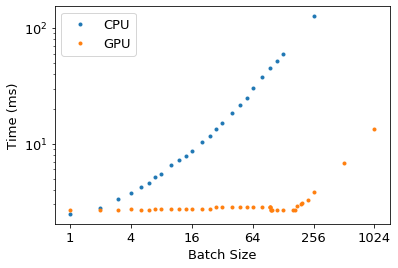

In [3]:
plt.loglog(data.iloc[:,0], data.iloc[:,1:], '.', basex=2)
plt.ylabel('Time (ms)')
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,256,1024])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(['CPU', 'GPU'])
plt.show()

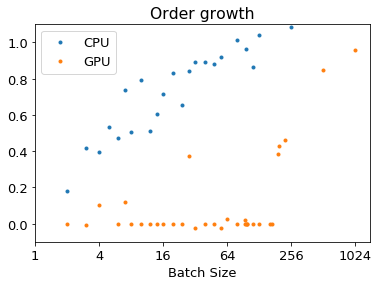

In [4]:
logdata = np.log(data)
cpulogdata = logdata.dropna()
cpudiff = cpulogdata.iloc[:,1].diff() / cpulogdata.iloc[:,0].diff()
gpudiff = logdata.iloc[:,2].diff() / logdata.iloc[:,0].diff()

plt.semilogx(np.exp(cpulogdata.iloc[:,0]), cpudiff, '.', basex=2)
plt.semilogx(np.exp(logdata.iloc[:,0]), gpudiff, '.', basex=2)
plt.title('Order growth')
plt.ylim([-.1,1.1])
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,256,1024])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(['CPU', 'GPU'])
plt.show()

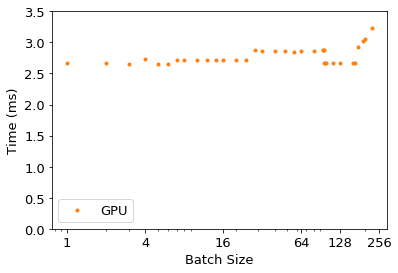

In [5]:
plt.semilogx(data.iloc[:-3,0], data.iloc[:-3,2], '.', color=plt.cm.tab10(1))
plt.legend(['GPU'], loc='lower left')
plt.ylabel('Time (ms)')
plt.ylim([0, 3.5])
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,128,256])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Torchscript timing
For a batch size of 1

In [1]:
import os
os.chdir('../src/')
import matplotlib.pyplot as plt
import numpy as np
import torch
from time import time
from dataset import board_to_planes
from engine import BigBoard
from network import UTTTNet
from selfplay import best_net

In [2]:
moves = [(7, 2), (2, 6), (6, 2), (2, 4), (4, 2), (2, 7), (7, 0), (0, 0), (0, 1), (1, 1), (1, 5), (5, 7), (7, 8), (8, 8), (8, 5), (5, 1), (1, 8), (8, 4), (4, 4), (4, 8), (8, 7), (7, 7), (7, 1), (1, 7), (3, 4), (4, 1), (1, 2), (2, 5), (5, 2), (2, 1), (5, 0), (0, 3), (3, 6), (6, 5), (5, 6)]
b = BigBoard()
for move in moves:
    b.move(*move)
b.draw()

     O │ X │   ┃   │ O │ X ┃   │ O │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │   │   ┃   │   │ X ┃   │ O │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │ O │ X ┃ O │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │   ┃   │ O │ X ┃ X │ O │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │ X │   ┃   │ X │   ┃   │   │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     X │   │   ┃   │   │ O ┃ X │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │ X ┃ X │ X │ X ┃   │   │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │ O ┃   │   │   ┃   │ O │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │ O │ X ┃   │ X │ O         
Mover: O, sector: (6,)
       │ X │ O 
    ───┼───┼───
       │   │   
    ───┼───┼───
       │ X │       


In [ ]:
# torch.backends.cudnn.benchmark = True
device = 'cpu'
trace = True

In [ ]:
print(f'Using network {best_net}')
m = UTTTNet()
m.load_state_dict(torch.load(f'../models/{best_net}.pt',
                             map_location=device))
m = m.to(device).eval()
with torch.no_grad():
    _ = m(board_to_planes(b).to(device))

if trace:
    m = torch.jit.trace(m, board_to_planes(b).to(device))

t = time()
v_total = 0
with torch.no_grad():
    for _ in range(1000):
        p, v = m(board_to_planes(b).to(device))
        v_total += v.item()
t = time() - t
print(f'Time (ms): {t}')
print(f'Value (mu): {v_total}')

#### Model eval results:
| Method              | Time (ms) per eval | w/o `board_to_planes` |
|:--------------------|:-------------------|:----------------------|
| CPU                 | 2.82               | 2.44                  |
| CPU Torchscript     | 2.14               | 1.72                  |
| GPU                 | 3.37               | 2.90                  |
| GPU w/ benchmarking | 3.13               | 2.67                  |
| GPU Torchscript     | 2.43               | 1.95                  |

Notes:
* Torchscript is 30% faster for model eval.
* Once I benchmarked cudnn, it stayed at the faster speed even when I turned it back off.

#### Optimizing `boards_to_planes`
| Method              | Time (ms) per eval |
|:--------------------|:-------------------|
| CPU                 | 0.39               |
| CPU Torchscript     | 0.33               |
| GPU                 | 0.41               |


Notes:
* 0.02 ms to move planes from cpu to cuda
* CPU torchscript is 15% faster but perhaps not worth the trouble of wrapping the function